##### Thursday the 5th of September, 2024
# BCHydro Energy Consumption Forecast with XGBoost
---

## Introduction
### Background

In British Columbia, BCHydro supplies over 95% of the population's electricity, primarily through renewable hydroelectric power. As the province's main energy provider, the utility company plays a key role in maintaining reliable energy access, powering industries, and sustaining vital infrastructure, all while promoting environmental stewardship and energy efficiency.

The ability for BCHydro to execute reliable and accurate energy demand forecasting is essential for efficient management and planning of power generation, distribution, and consumption. In general, predicting energy demand is a challenging task, as it is shaped by various factors such as weather conditions, economic trends, and societal behaviors. This project explores the development of a forecasting model using machine learning techniques to predict future energy demand.

### Objective

 The goal of this project is to employ the XGBoost library and cross-validation techniques in developing a machine learning model that can predict/estimate future energy consumption levels based on historical BCHydro time-series data. 


## Dataset description
The dataset used in this project is called [The Hourly Usage of Energy Dataset for Buildings in British Columbia](https://dataverse.harvard.edu/dataset.xhtml?persistentId=doi:10.7910/DVN/N3HGRN&version=5.0&selectTab=termsTab).

This dataset consists of hourly energy consumption data in kilowatts per hour, donated by residential customers of BCHydro, the primary provincial power utility company of British Columbia, Canada. The sample contains data from 22 homes, the majority of which have 3 years of historical consumption data as limited by the BCHydro customer portal from which the data was sourced.

The date range in which data is present is from June 1, 2012 to May 19, 2020

----


## Python Modules
The following python libraries were used in this project:

- pandas
- numpy
- matplotlib
- seaborn
- Scikit-learn
- datetime
- math


In [1]:
# Import necessary libraries
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline
import datetime as dt
import seaborn as sns
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit
from sklearn.impute import KNNImputer
import math 
color_palette = sns.color_palette()
plt.style.use('fivethirtyeight')

---
## Load the Data

In [2]:
# Load energy consumption datasets into a single dataframe
file_name = "kWh_data/Residential_{}.csv"
df_list = []
for i in range(1, 29):
    df_list.append(pd.read_csv(file_name.format(i)))
df = pd.concat(df_list)

# Combine 'date' and 'hour' into datetime column
df["datetime"] = pd.to_datetime(df["date"]) + pd.to_timedelta(df["hour"], unit="h")

# Drop 'date', 'hour'
df = df.drop(["date", "hour"], axis="columns")

# Set index
df = df.set_index("datetime")

# Set timezone
df.tz_localize(None)

df

,energy_kWh
datetime,
2012-06-01 01:00:00,1.011
2012-06-01 02:00:00,0.451
2012-06-01 03:00:00,0.505
2012-06-01 04:00:00,0.441
2012-06-01 05:00:00,0.468
...,...
2020-05-19 19:00:00,3.060
2020-05-19 20:00:00,2.940
2020-05-19 21:00:00,1.970


In [3]:
# Count of NaN values in each column
df.isnull().sum()

energy_kWh    5037
dtype: int64

In [4]:
# Return rows with NaN value in 'energy_kWh' column
df[df["energy_kWh"].isnull()]

,energy_kWh
datetime,
2016-07-02 21:00:00,NaN
2016-07-09 12:00:00,NaN
2016-07-30 01:00:00,NaN
2016-07-30 02:00:00,NaN
2016-07-30 03:00:00,NaN
...,...
2019-12-27 10:00:00,NaN
2019-12-29 03:00:00,NaN
2020-01-01 04:00:00,NaN


In [5]:
# K Next Neighbours Imputer
imputer = KNNImputer(n_neighbors=1)
columns = ["energy_kWh"]

# Perform Imputation
for column in columns:
    df[column] = imputer.fit_transform(
        pd.DataFrame(df[column])
    )  # May take a couple minutes to execute

In [6]:
# Verify imputation success
df.isnull().sum()

energy_kWh    0
dtype: int64

---
## Exploratory Data Analysis
### Data Visualization
First, let's take a look at all of the energy consumption data across all available dates:

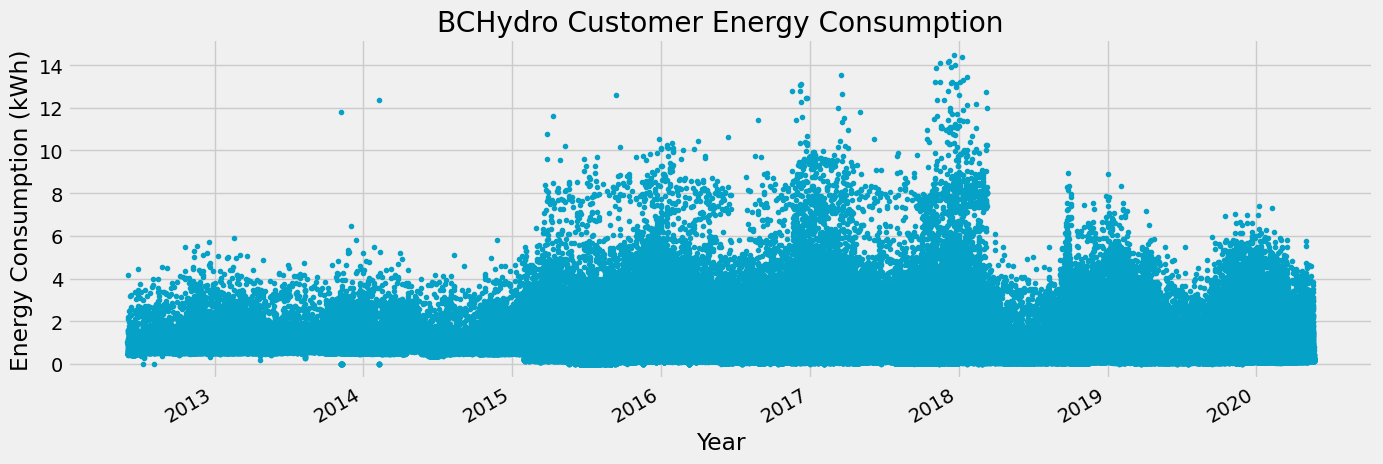

In [7]:
# Plot data frame
df["energy_kWh"].plot(
    style=".",
    figsize=(15, 5),
    title="BCHydro Customer Energy Consumption",
    color="#05a1c6",
)
plt.xlabel("Year")
plt.ylabel("Energy Consumption (kWh)");

---
## Time Series Cross-Validation

In [17]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365, gap=24)
df = df.sort_index()

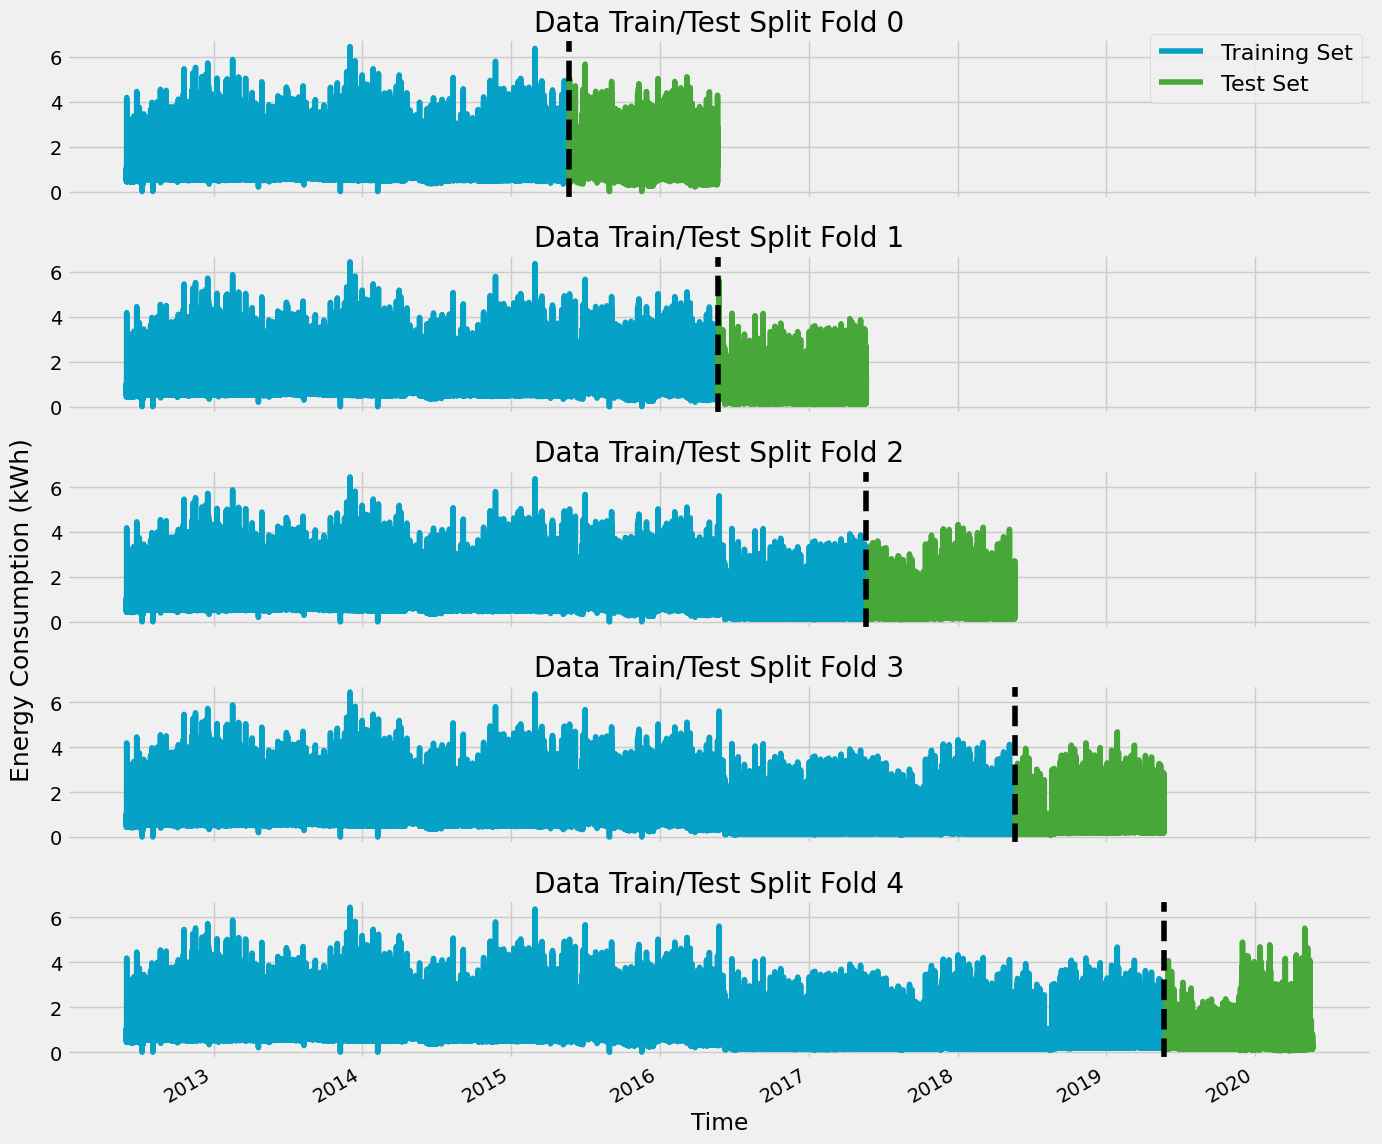

In [46]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["energy_kWh"].plot(
        ax=axs[fold],
        label="Training Set",
        title=f"Data Train/Test Split Fold {fold}",
        fontsize = 14,
        color="#05a1c6",
    )    
    test["energy_kWh"].plot(ax=axs[fold], label="Test Set", color="#48a739")
    axs[fold].axvline(test.index.min(), color="black", ls="--")
    fold += 1

plt.legend(loc=(0.83, 6), fontsize=16)
plt.xlabel("Time")
fig.text(
    0.05,
    0.5,
    "Energy Consumption (kWh)",
    ha="center",
    va="center",
    rotation="vertical",
    fontsize=18,
)
plt.subplots_adjust(
    left=None, bottom=None, right=None, top=None, wspace=None, hspace=0.35
)


---
## Feature Engineering
For a more robust predictive analysis, we create and employ a function to add a number of time-based features to our data, as derived from the datetime index in our dataframe. The added features are as follows:
- `hour`
- `dayofweek`
- `quarter`
- `month`
- `year`
- `dayofyear`

The code below creates our function:

In [ ]:
def make_features(data):
    data = data.copy()
    data["hour"] = data.index.hour
    data["dayofweek"] = data.index.dayofweek
    data["quarter"] = data.index.quarter
    data["month"] = data.index.month
    data["year"] = data.index.year
    data["dayofyear"] = data.index.dayofyear
    return data

In [ ]:
df = make_features(df)

In [ ]:
# Remove duplicate index values
df = df[~df.index.duplicated()]

# Remove outliers
df = df[df["energy_kWh"] < 8]

### Visualizing Feature Relationships

Next, we will create two box plots to we will visualize the relationship between our newly added `hour` and `month` features and energy consumption. These visualizations allow us to view the distribution of energy consumption throughout the hours of the day, and throughout the months of the year.

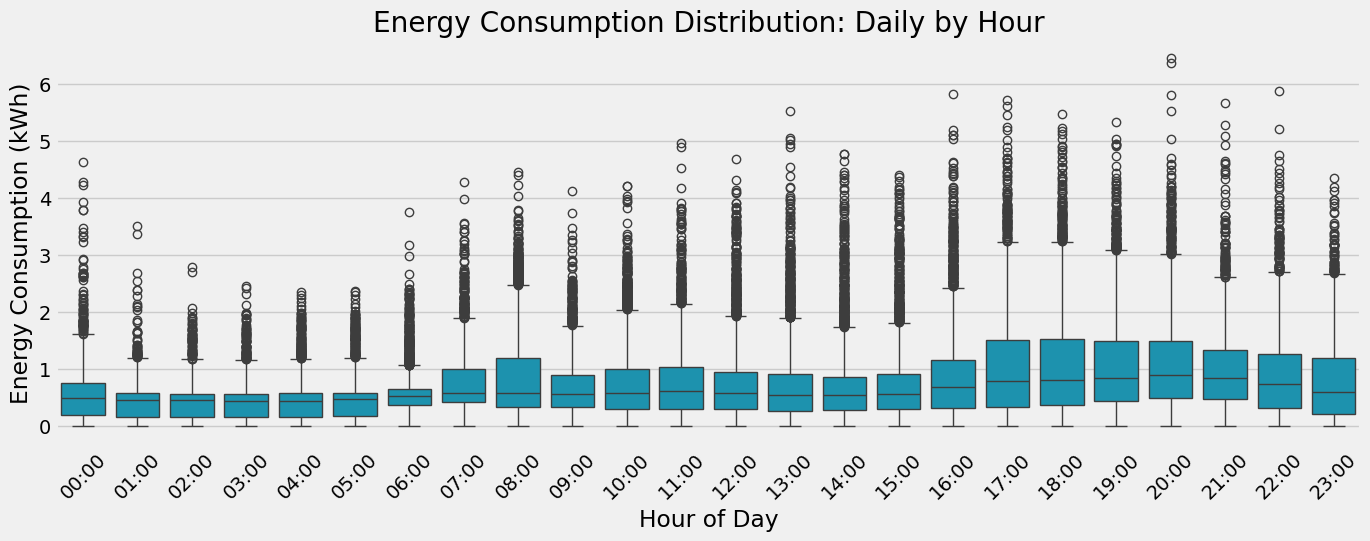

In [ ]:
hours = [f"{i:02d}:00" for i in range(24)]
fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(data=df, x="hour", y="energy_kWh", color="#05a1c6")
ax.set_xticks(range(0, 24), labels=hours, rotation=45)
plt.ylabel("Energy Consumption (kWh)")
plt.xlabel("Hour of Day")
plt.title("Energy Consumption Distribution: Daily by Hour");

Text(0.5, 1.0, 'Energy Consumption Distribution: Yearly by Month')

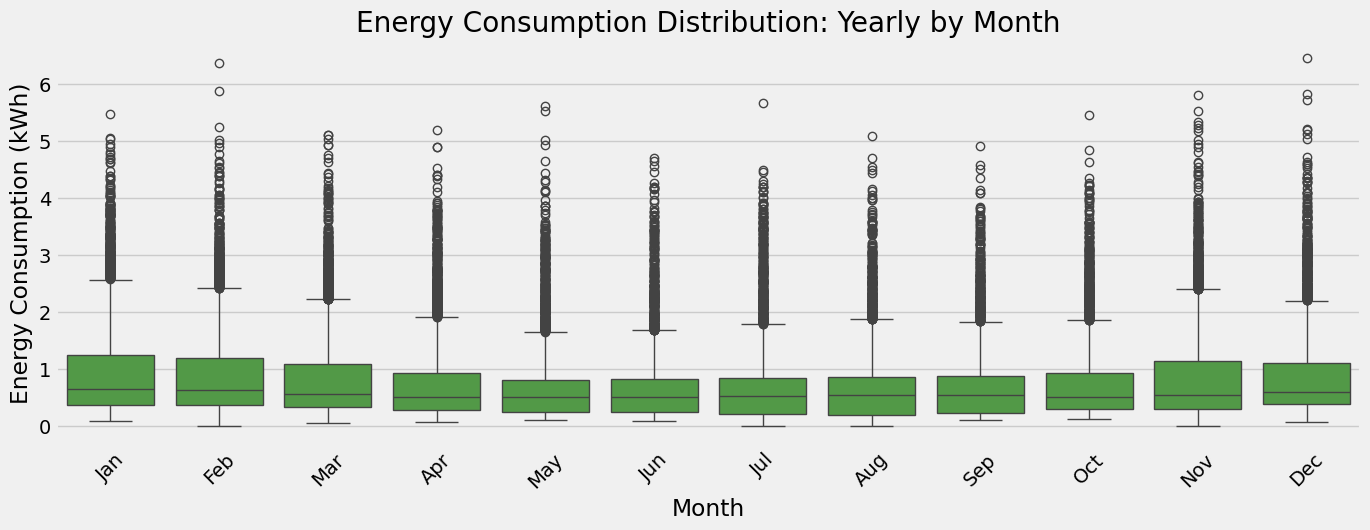

In [ ]:
months = [
    "Jan",
    "Feb",
    "Mar",
    "Apr",
    "May",
    "Jun",
    "Jul",
    "Aug",
    "Sep",
    "Oct",
    "Nov",
    "Dec",
]
fig, ax = plt.subplots(figsize=(15, 5))

sns.boxplot(data=df, x="month", y="energy_kWh", color="#48a739")
ax.set_xticks(range(0, 12), labels=months, rotation=45)
plt.ylabel("Energy Consumption (kWh)")
plt.xlabel("Month")
plt.title("Energy Consumption Distribution: Yearly by Month");

---
## Lag Features
Adding lag features to our dataframe allows our model to make more robust predictions, as it effectively gives our model historical context by including historical energy consumption values as features. We will add three lag features, corresponding to one, two, and three years, or 364, 728, and 1092 days in the past respectively. 

In [15]:
target_map = df["energy_kWh"].to_dict()

In [16]:
# Define function to add lag features
def add_lags(df):
    df["lag1"] = (df.index - pd.Timedelta("364 days")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("728 days")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("1092 days")).map(target_map)
    return df

In [17]:
add_lags(df)

,energy_kWh,hour,dayofweek,quarter,month,year,dayofyear,lag1,lag2,lag3
datetime,,,,,,,,,,
2012-06-01 01:00:00,1.011,1,4,2,6,2012,153,NaN,NaN,NaN
2012-06-01 02:00:00,0.451,2,4,2,6,2012,153,NaN,NaN,NaN
2012-06-01 03:00:00,0.505,3,4,2,6,2012,153,NaN,NaN,NaN
2012-06-01 04:00:00,0.441,4,4,2,6,2012,153,NaN,NaN,NaN
2012-06-01 05:00:00,0.468,5,4,2,6,2012,153,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2020-05-20 19:00:00,0.270,19,2,2,5,2020,141,0.32,0.76,0.49
2020-05-20 20:00:00,0.280,20,2,2,5,2020,141,0.46,0.63,0.35
2020-05-20 21:00:00,0.280,21,2,2,5,2020,141,0.52,0.97,0.53


### Training Model with Cross-Validation
We perform 5-fold cross validation on the data, scoring the model using the root mean squared error.

In [18]:
tss = TimeSeriesSplit(n_splits=5, test_size=24 * 365 * 1, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = make_features(train)
    test = make_features(test)

    feats = [
        "dayofyear",
        "hour",
        "dayofweek",
        "quarter",
        "month",
        "year",
        "lag1",
        "lag2",
        "lag3",
    ]
    target = "energy_kWh"

    X_train = train[feats]
    y_train = train[target]

    X_test = test[feats]
    y_test = test[target]

    reg = xgb.XGBRegressor(
        base_score=0.5,
        booster="gbtree",
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:squarederror",
        max_depth=3,
        learning_rate=0.01,
    )
    reg.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
    )

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:0.90952	validation_1-rmse:0.86021
[100]	validation_0-rmse:0.63756	validation_1-rmse:0.64752
[200]	validation_0-rmse:0.58337	validation_1-rmse:0.62611
[276]	validation_0-rmse:0.57205	validation_1-rmse:0.62725
[0]	validation_0-rmse:0.89714	validation_1-rmse:0.45189
[49]	validation_0-rmse:0.72342	validation_1-rmse:0.53797
[0]	validation_0-rmse:0.82746	validation_1-rmse:0.42008
[100]	validation_0-rmse:0.62206	validation_1-rmse:0.39629
[200]	validation_0-rmse:0.57644	validation_1-rmse:0.38614
[300]	validation_0-rmse:0.56001	validation_1-rmse:0.38561
[303]	validation_0-rmse:0.55970	validation_1-rmse:0.38577
[0]	validation_0-rmse:0.77423	validation_1-rmse:0.40882
[100]	validation_0-rmse:0.58577	validation_1-rmse:0.38471
[200]	validation_0-rmse:0.54776	validation_1-rmse:0.38016
[300]	validation_0-rmse:0.53332	validation_1-rmse:0.37519
[400]	validation_0-rmse:0.52689	validation_1-rmse:0.37273
[500]	validation_0-rmse:0.52346	validation_1-rmse:0.37226
[600]	validation_0-rmse

In [19]:
print(f"Mean Score: {np.mean(scores):0.4f}")
print(f"Score by fold: {scores}")

Mean Score: 0.4860
Score by fold: [0.6258560172322173, 0.4518899047123867, 0.3844881159145239, 0.37203722712345405, 0.5956534320383671]


---
## Future Predictions

In [20]:
# Retrain on all data
df = make_features(df)

feats = [
    "dayofyear",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "lag1",
    "lag2",
    "lag3",
]
target = "energy_kWh"

X_all = df[feats]
y_all = df[target]

reg = xgb.XGBRegressor(
    base_score=0.5,
    booster="gbtree",
    # Adjust n_estimators to accountu for overfitting
    n_estimators=500,
    objective="reg:linear",
    max_depth=3,
    learning_rate=0.01,
)
reg.fit(X_all, y_all, eval_set=[(X_all, y_all)], verbose=100)

[0]	validation_0-rmse:0.71739
[100]	validation_0-rmse:0.56710


c:\Users\noah8\AppData\Local\Python\Python3.11\Lib\site-packages\xgboost\core.py:160: UserWarning: [14:14:22] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0b3782d1791676daf-1\xgboost\xgboost-ci-windows\src\objective\regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:0.53156
[300]	validation_0-rmse:0.51762
[400]	validation_0-rmse:0.51017
[499]	validation_0-rmse:0.50613


XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=500, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [21]:
# Latest day in our data
df.index.max()

Timestamp('2020-05-20 23:00:00')

In [22]:
# Create future dataframe
future = pd.date_range("2020-05-20 23:00:00", "2021-05-20 3:020:00", freq="1h")
future_df = pd.DataFrame(index=future)
future_df["isFuture"] = True
df["isFuture"] = False
df_and_future = pd.concat([df, future_df])
df_and_future = make_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query("isFuture").copy()

AttributeError: module 'matplotlib.pyplot' has no attribute 'set_title'

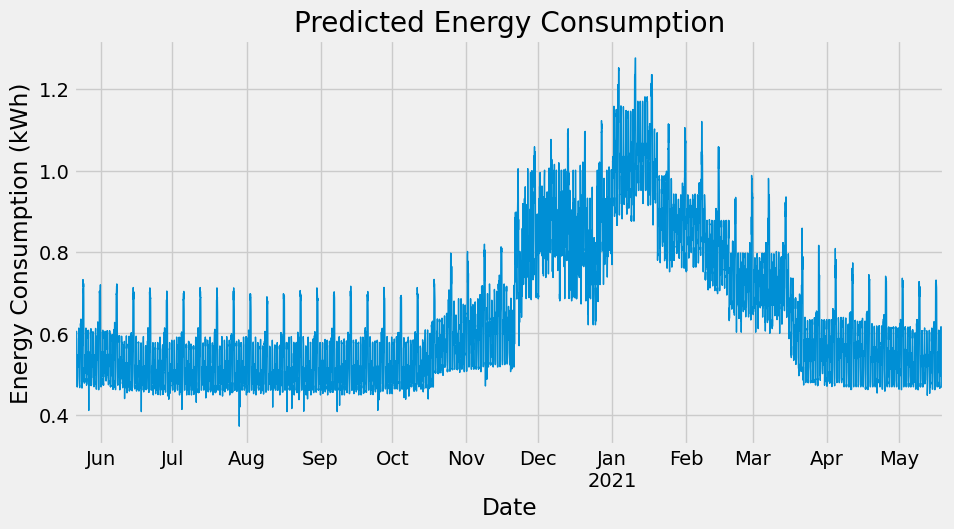

In [23]:
future_w_features["pred"] = reg.predict(future_w_features[feats])
future_w_features["pred"].plot(figsize=(10, 5), ms=1, lw=1, title="Predicted Energy Consumption")

plt.ylabel("Energy Consumption (kWh)")
plt.xlabel("Date")
plt.set_title("Energy Consumption Forecast: Week of July 13, 2020");

### Estimated Future Average Weekly Energy Consumption
Using the future prediction data, we will estimate the average weekly energy consumption for future weeks.

#### Seasonal Consumption Comparison
Suppose we are interested in comparing the energy consumption for two given weeks, six months apart; one in the summer, and one in the winter. Let's arbitrarily compare the weeks of July 13, 2020 and January 11, 2021. 

In [98]:
# Week of July 13, 2020
jul12_cons = future_w_features[
    (future_w_features["dayofyear"] >= 195) & (future_w_features["dayofyear"] <= 201)
]["pred"].sum()

# Week of January 11, 2021
jan11_cons = future_w_features[
    (future_w_features["dayofyear"] >= 11) & (future_w_features["dayofyear"] <= 17)
]["pred"].sum()

print("Average Energy Consumption:")
print(f"Week of July 13, 2020: {jul12_cons:0.4f} kW")
print(f"Week of January 11, 2020: {jan11_cons:0.4f} kW")

Average Energy Consumption:
Week of July 13, 2020: 87.0480 kW
Week of January 11, 2020: 176.8319 kW


#### Visualizing Future Prediction
We can also visualize these two weeks of estimated values to get an idea of how the average energy consumption varies by day of the week. First, let's view the week of July 13, 2020:

C:\Users\noah8\AppData\Local\Temp\ipykernel_15408\2466733936.py:12: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dates)


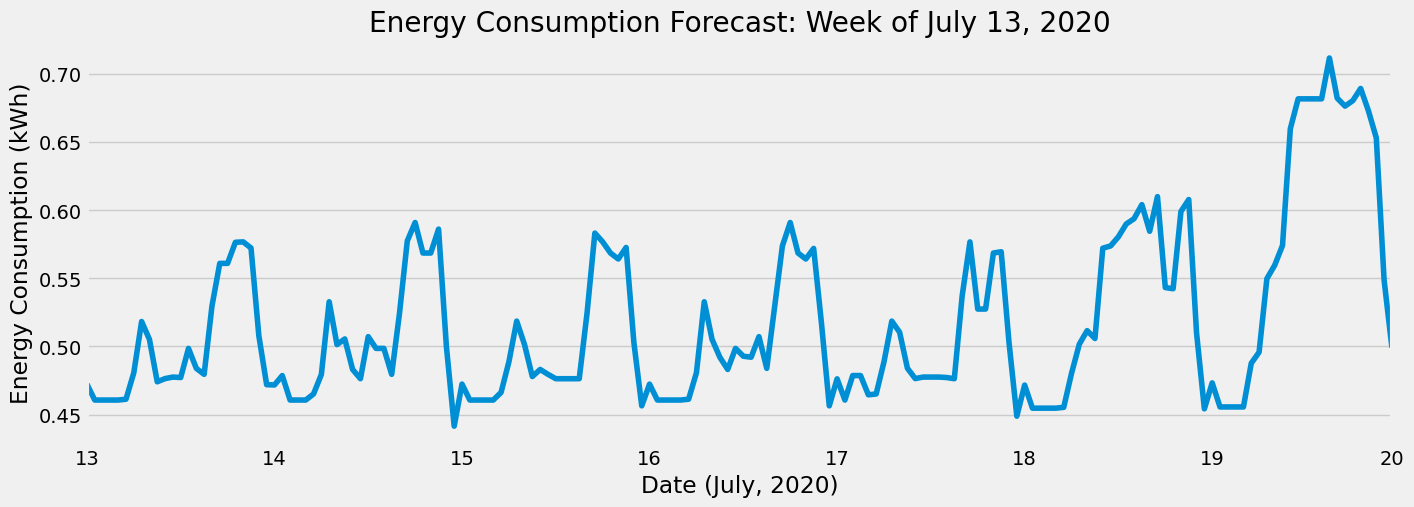

In [212]:
# Min, max x-axis tick label
dates = [13, 20]
    
# Plotting predicted values for the week of July 13, 2020
ax = (
    future_w_features["pred"]
    .loc[
        (future_w_features["dayofyear"] >= 195)
        & (future_w_features["dayofyear"] <= 201)
    ]
    .plot(figsize=(15, 5), title="Week of Predictions")
)

# Set plot attributes
ax.set_xticklabels(dates)
ax.set_ylabel("Energy Consumption (kWh)")
ax.set_xlabel("Date (July, 2020)")
ax.set_title("Energy Consumption Forecast: Week of July 13, 2020");

Now, let's visualize the predicted energy consumption for the week of January 11, 2021:

C:\Users\noah8\AppData\Local\Temp\ipykernel_15408\812824184.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(dates)


Text(0.5, 1.0, 'Energy Consumption Forecast: Week of January 11, 2021')

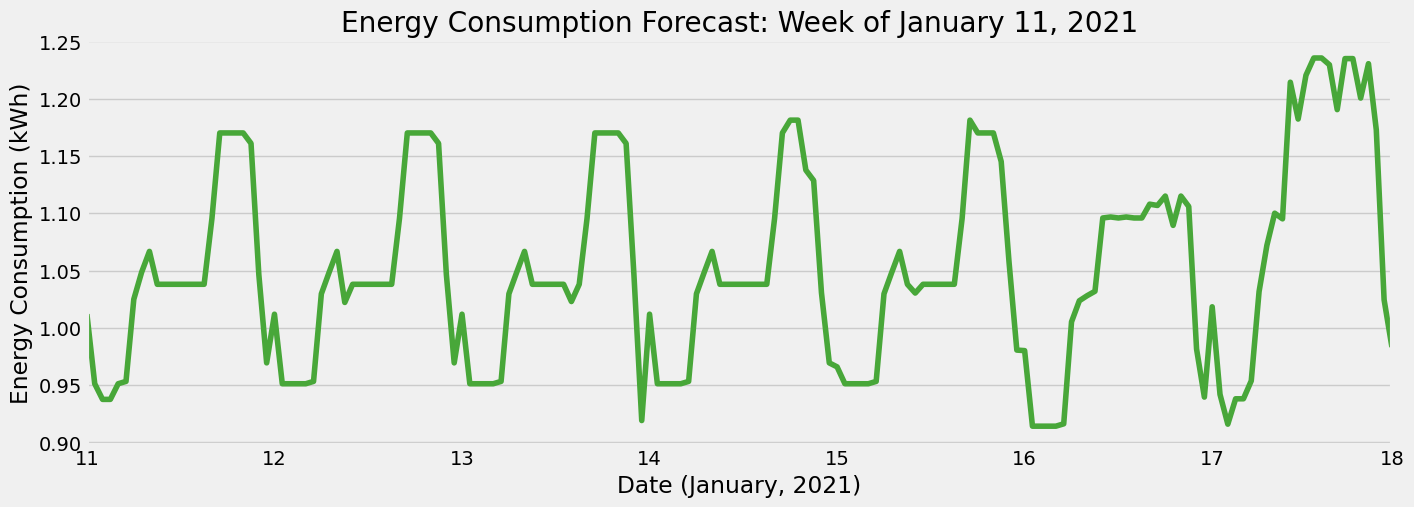

In [214]:
# Min, max x-axis tick labels
dates = [11, 18]

# Plotting predicted values for the week of January 11, 2021
ax = (
    future_w_features["pred"]
    .loc[
        (future_w_features["dayofyear"] >= 11) & (future_w_features["dayofyear"] <= 17)
    ]
    .plot(figsize=(15, 5), color="#48a739")
)

# Set plot attributes
ax.set_xticklabels(dates)
ax.set_ylabel("Energy Consumption (kWh)")
ax.set_xlabel("Date (January, 2021)")
ax.set_title("Energy Consumption Forecast: Week of January 11, 2021");

## Discussion
The predictions/estimates provided by the model developed in this project has the potential to offer BC Hydro several key benefits. Such insights allow for ***more efficient resource management*** by optimizing power generation and distribution, ensuring a reliable supply without overproduction or shortages. 

Forecasting also supports better infrastructure planning and maintenance, reducing costs and preventing outages. Additionally, it allows for ***improved integration of renewable energy sources***, balancing demand with variable supply from sources like wind or solar. This, in addition to other predictive insights, help BC Hydro manage peak demand more effectively, offering customers cost-saving initiatives and contributing to a more sustainable energy system.